# Préparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 1


In [3]:
# IMPORT
import numpy

import keras
from keras import optimizers
from keras.datasets import cifar10 # we can use also cifar100
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

import matplotlib.pyplot as plt

import sklearn
import sklearn.metrics

#print(sklearn.__version__)

Using TensorFlow backend.


In [4]:
# LOAD DATA
num_classes = 10
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
#!pip install -q keract 
from keract import get_activations

In [6]:
# LOAD MODELS
model0 = load_model('models/model0.h5')
model0.load_weights('models/model0_weights25.h5')
model1 = load_model('models/model1.h5')
model1.load_weights('models/model1_weights25.h5')
model2 = load_model('models/model2.h5')
model2.load_weights('models/model2_weights25.h5')

In [7]:
# EVALUATION
# Final evaluation of the models
scores0 = model0.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores0[0])
print('Test accuracy:', scores0[1])
print("Model 1 CNN Error: %.2f%%" % (100-scores0[1]*100))
scores1 = model1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores1[0])
print('Test accuracy:', scores1[1])
print("Model 1 CNN Error: %.2f%%" % (100-scores1[1]*100))
scores2 = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores2[0])
print('Test accuracy:', scores2[1])
print("Model 2 Error: %.2f%%" % (100-scores2[1]*100))

10000/10000 [==============================] - 2s 176us/step
Test loss: 0.7553634172439575
Test accuracy: 0.7527
Model 1 CNN Error: 24.73%
10000/10000 [==============================] - 1s 73us/step
Test loss: 1.7675633235931396
Test accuracy: 0.3616
Model 1 CNN Error: 63.84%
10000/10000 [==============================] - 1s 74us/step
Test loss: 1.356453879547119
Test accuracy: 0.5082
Model 2 Error: 49.18%


# ACTIVATIONS

## Mutual information

Regarder l'information mutuelle AVEC DES INT #binaires (! restriction d'arrondi)

In [8]:
# On regarde l'activation des neurones pour un echantillon test
Echantillon = [x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5], x_test[6], x_test[7], x_test[8], x_test[9], x_test[10], x_test[11], x_test[12], x_test[13]]
IM0 = get_activations(model0, Echantillon)
# on affiche les noms des differentes couches
print(IM0.keys())

IM1 = get_activations(model0, Echantillon)
print(IM1.keys())

IM2 = get_activations(model0, Echantillon)
print(IM2.keys())


dict_keys(['activation_4/Relu:0', 'max_pooling2d_1/MaxPool:0', 'activation_3/Relu:0', 'dropout_2/cond/Merge:0', 'dense_1/BiasAdd:0', 'conv2d_4/BiasAdd:0', 'activation_6/Softmax:0', 'max_pooling2d_2/MaxPool:0', 'conv2d_3/BiasAdd:0', 'conv2d_2/BiasAdd:0', 'conv2d_1/BiasAdd:0', 'dropout_3/cond/Merge:0', 'activation_1/Relu:0', 'activation_5/Relu:0', 'activation_2/Relu:0', 'flatten_1/Reshape:0', 'dropout_1/cond/Merge:0', 'dense_2/BiasAdd:0'])
dict_keys(['activation_4/Relu:0', 'max_pooling2d_1/MaxPool:0', 'activation_3/Relu:0', 'dropout_2/cond/Merge:0', 'dense_1/BiasAdd:0', 'conv2d_4/BiasAdd:0', 'activation_6/Softmax:0', 'max_pooling2d_2/MaxPool:0', 'conv2d_3/BiasAdd:0', 'conv2d_2/BiasAdd:0', 'conv2d_1/BiasAdd:0', 'dropout_3/cond/Merge:0', 'activation_1/Relu:0', 'activation_5/Relu:0', 'activation_2/Relu:0', 'flatten_1/Reshape:0', 'dropout_1/cond/Merge:0', 'dense_2/BiasAdd:0'])
dict_keys(['activation_4/Relu:0', 'max_pooling2d_1/MaxPool:0', 'activation_3/Relu:0', 'dropout_2/cond/Merge:0', 'den

In [9]:
nameOfTheCouche = 'activation_5/Relu:0' #name of the couche to analyze

In [16]:
def MI(nameOfTheCouche):
    
    numActivations = len(IM0[nameOfTheCouche])
    print('number of data used for activation : '+str(numActivations))
    numNeurons = len(IM0[nameOfTheCouche][0])
    print('number of neurons for the layer: '+str(numNeurons))

    #print(IM0[nameOfTheCouche])
    #plt.imshow(IM0[nameOfTheCouche])
    #plt.show()
    
    
    # on selectionne des pair de neurones (X,Y) à comparer (regarder l'information mutuelle entre X et Y)
    NombrePairs = 100

    NeuronsSelected = numpy.zeros((NombrePairs,2))  # initialize

    for i in range(NombrePairs):
        NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)  # on prend 2 neurones selectionnées aleatoirement
        # les 2 neurones doivent être différents
        while NeuronsSelected[i][0] == NeuronsSelected[i][1]:
            NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)

    #print(NeuronsSelected[56])
    #print(NeuronsSelected[56][0])
    
    MutualInfo = numpy.zeros((NombrePairs,1))  # initialization des resultats

    for j in range(NombrePairs):
        X = numpy.zeros((numActivations,1))  # initialization du vecteur X
        Y = numpy.zeros((numActivations,1))  # initialization du vecteur y

        i = 0
        for activation in IM0[nameOfTheCouche]:   # pour chaque element de l'echantillon (= chaque activation)
            #print(activation)

            X[i] = activation[int(NeuronsSelected[j][0])-1] # on regarde l'activation du neurone selectionné
            Y[i] = activation[int(NeuronsSelected[j][1])-1]

            # On binarise : RELU
            if X[i] > 0:
                X[i] = 1
            else:
                X[i] = 0
            if Y[i] > 0:
                Y[i] = 1
            else:
                Y[i] = 0

            i = i+1

        X = X.flatten()
        Y = Y.flatten()
        #print(X)
        #print(Y)

        # example:= sklearn.metrics.normalized_mutual_info_score([1.1,1.0,1.0,1.0,0.0],[1.1,0.1,0.1,1.1,0.1])
        MutualInfo[j] = sklearn.metrics.normalized_mutual_info_score(X,Y)
        #print(MutualInfo[j])

    return MutualInfo

number of data used for activation : 14
number of neurons for the layer: 512


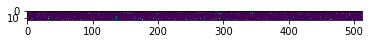

/linux/mnovak/Documents/Thesis/Code/myenv/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [11]:
MutualInfo = MI(nameOfTheCouche)

In [17]:
from collections import defaultdict

dMI0 = defaultdict(list)
dMI1 = defaultdict(list)
dMI2 = defaultdict(list)

for layer_idx, name_couche in enumerate(get_activations(model0, Echantillon)):
    dMI0[layer_idx] = MI(name_couche)
    
for layer_idx, name_couche in enumerate(get_activations(model1, Echantillon)):
    dMI1[layer_idx] = MI(name_couche)
    
for layer_idx, name_couche in enumerate(get_activations(model2, Echantillon)):
    dMI2[layer_idx] = MI(name_couche)

number of data used for activation : 14
number of neurons for the layer: 13


ValueError: could not broadcast input array from shape (13,64) into shape (1)

In [ ]:
dMI = [dMI0, dMI1, dMI2]
f, axs = plt.subplots(n_layers, 3, figsize=(15,15))
for layer in range(n_layers):
    for i in range(3):
        #axs[layer,i].subplot(n_layers,3,(i+1)+layer*3)
        axs[layer,i].hist(dMI[i][layer], bins=100, histtype='stepfilled')  # arguments are passed to np.histogram

f.show()

## Métrique Linéaire

Regarder la métrique spéciale de l'article pour comparer ce qu'apporte un neurone par rapport à tous les autres neurones de la couche (! restriction linéaire)
* https://arxiv.org/pdf/1706.05806.pdf